# Sentiment Analysis of Tweets using spaCy, VADER, and Scikit-Learn

This notebook will showcase two approaches to conducting sentiment analysis in a natural language processing (NLP) pipeline.  

Both approach will attempt to resolve tweets to a continuum of sentiment based on the content of each tweet.  The sentiment values produced could then further be classified into postive vs negative groups, which would be as simple as choosing an arbitrary threshold sentiment value (i.e. 0) and sorting each tweet into their respective bins.

1. Lexicon Approach

    - This approach will cross reference the salient words of each tweet against a lexicon that prescribes a sentiment valence value, which will be an integer value. 
    - These integer values will be summed for each tweet to compute its compound sentiment.
    
<br>

2. Machine Learning Approach

 - The second approach will train a machine learning regression model after representing each tweet as a vector in some n-dimensional space.
 - Each tweet will be transformed into a sparse matrix within a high dimensional space so that they can be presented to our regression models as numbers.

<br>

All the code for this notebook will be in Python.

## 1. Setup

We're going to write a tiny amount of functions ourselves, but mostly leverage functions from open-source packages.

This part is really <font color=green>**import**</font>ant.

In [2]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import SGDRegressor

In [6]:
def tokenize(x, flatten=False):
    '''Preprocess the input text by tokenizing each word,
    removing stopwords, removing any punctuation, and 
    converting words into their lemmas.
    
    Args:
        x: Corpus list where each item is a text document
        flatten: Decide if the returned list should be flat 1D or 2D
    
    Returns:
        Produces a list of preprocessed lemmas in the same order as x.
    '''
    
    toktext = []
    for t in x:
        # Create a tokenized lang obj for each doc
        doc = nlp(t)
        
        # Remove stopwords, punctuation & pronouns, then record lemmas
        lemmas = [token.lemma_ for token in doc 
                   if (not token.is_stop and 
                       not token.is_punct and 
                       token.lemma_ != '-PRON-')]
        
        if flatten:
            # Concatenate the lemma strings into a single string 
            concat_lemma = " ".join(lemmas)
            toktext.append(concat_lemma)
        
        else:
            toktext.append(lemmas)
        
    return toktext


def sentiment_scatterplot(X, y, title=""):
    '''Graph a scatter plot of the sentiment scores as a function
    of tweet length.
    
    Args:
        X: List of tweet length values
        y: List of sentiment scores
        title: The graph title
    
    Returns:
        A matplotlib pyplot object
    '''
    plt.figure(figsize=(10, 7))

    # Define colormap scale
    norm = Normalize(-1,1)
    colors = [[norm(-1.0), "crimson"],
              [norm( 0.0), "darkgrey"],
              [norm( 1.0), "dodgerblue"]]

    cmap = LinearSegmentedColormap.from_list("", colors)

    plt.scatter(X, y, c=y, cmap=cmap)
    plt.xlabel('Tweet Character Count')
    plt.ylabel('Sentiment')
    plt.title(title)
    
    return plt

## 2. Read Datasets into Memory

The *Sentiment140_test* dataset is going to serve as our target dataset, where we will be interest in discovering what the spread of sentiment looks like for these 498 tweets.
([GitHub](https://github.com/rmaestre/Sentiwordnet-BC/blob/master/test/testdata.manual.2009.06.14.csv), [Kaggle](https://www.kaggle.com/pirateshadow/sentiment140-test))

The machine learning training dataset we're going to use comes from the VADER package.  It is a list of tweet-like text with labelled sentiment values. ([GitHub](https://github.com/cjhutto/vaderSentiment#python-code-example))

In [4]:
target_data_fpath = '~/Documents/datasets/nlp/testdata.manual.2009.06.14.csv'
target_df = pd.read_csv(target_data_fpath, header=None)

mltrain_fpath = '~/Documents/datasets/nlp/tweets_GroundTruth.txt'
mltrain_df = pd.read_csv(mltrain_fpath, delimiter='\t', 
                         engine='python', header=None,
                         names = ['id', 'mean_sentiment_rating', 'tweet_text'])

## 3. Tokenize Words with spaCy

The `spaCy` package provides a concise way to preprocess our tweet texts into tokens for our NLP pipeline.  

The `spaCy` package can be thought of as an industry-focused `NLTK` package.

In [7]:
# Initialize spaCy English model
nlp = spacy.load('en')

# Isolate the text from our target dataframe
target_tweets = textdf.iloc[:, 5].tolist()
print('Example of a target tweet:\n', target_tweets[1])

Example of a target tweet:
 Reading my kindle2...  Love it... Lee childs is good read.


Our tokenization steps will be: 

1. Remove stopwords

2. Remove punctuation

3. Remove pronounds

4. Convert words to lemma

In [12]:
lexicon_target_tokens = tokenize(target_tweets, flatten=True)
print('Example of same tweet tokenized:\n', lexicon_target_tokens[1])

Example of same tweet tokenized:
 read kindle2   love lee child good read


## 4. Lexicon Approach to Sentiment Analysis

We will call on the `VADER` lexicon to compute the summed sentiments using each tweets' lemmas.

In [15]:
analyzer = SentimentIntensityAnalyzer()
sentiments = []

for tweet in lexicon_target_tokens:
    polarity = analyzer.polarity_scores(tweet)
    sentiments.append(polarity)
    
print('Example of sentiment value for same target tweet:\n', sentiments[1]['compound'])

Example of sentiment value for same target tweet:
 0.7964


Below is the explanation, in their own words, of how VADER computes the compound (i.e. combined/summed) sentiment for each tweet.

"The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate."

[GitHub](https://github.com/cjhutto/vaderSentiment#python-code-example)

### Lexicon Approach Visualized

Let's get a pre-attentive sense for what the sentiments look like.

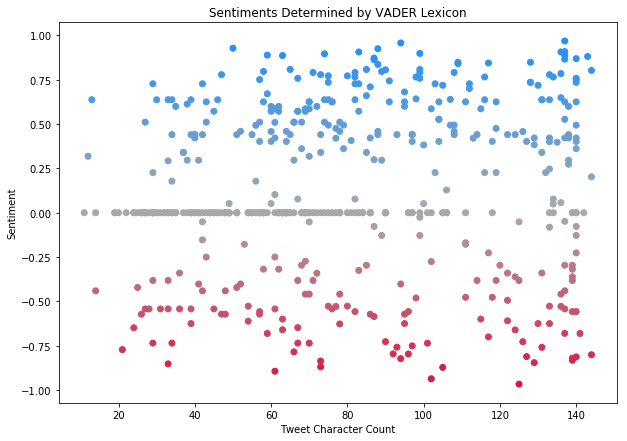

In [16]:
X =  [len(tweet) for tweet in target_tweets]
y = [x['compound'] for x in sentiments]
ptitle = 'Sentiments Determined by VADER Lexicon'

sentiment_scatterplot(X, y, ptitle);

## 5. Machine Learning Approach to Sentiment Analysis

This approach is going to train a machine learning model to resolve the sentiment for each of the tweets within our target dataset.  We will need to vectorize our tweet text data as an additional preprocessing step in this approach.

In [19]:
mltrain_tweets = [text for text in mltrain_df.tweet_text]

# Flatten the output of tokenize and save as a new column within our machine learning training dataframe
mltrain_df['tokens'] = tokenize(mltrain_tweets, flatten=True)
mltrain_df.head(5)

,id,mean_sentiment_rating,tweet_text,tokens
0,1,2.726316,Somehow I was blessed with some really amazing...,somehow bless amazing friend life love send en...
1,2,1.443299,Yay. Another good phone interview.,yay another good phone interview
2,3,2.873684,We were 17 deep last night &amp; the love was ...,17 deep night amp love strong everybody feel e...
3,4,2.857143,"LMAO, AMAZING!",lmao amazing
4,5,-2.154639,Two words that should die this year: Sexting a...,two word die year sexting jegging die die die


We will vectorize our tweet data by creating a sparse matrix of token counts to represent the tweets as numerical values using `CountVectorizer` from scikit-learn.

We will constrain the high dimensional space of our vectors by setting the `max_features` to that of our target dataset (the smaller of the two datasets, with a lesser dimensional space).

In [20]:
# Initialize vectorizer object
countvec = CountVectorizer()

# First pass at vectorizing tweets
target_dataset = countvec.fit_transform(target_tweets)
training_dataset = countvec.fit_transform(mltrain_df.tokens)

# Set the max feature space to the smaller of the two datasets in an automated way
ndims = [np.shape(x)[1] for x in [target_dataset, training_dataset]]
smaller = min(ndims)

# Re-fit the vectorizers, limit their dimensional space to the smaller of the 2 spaces
countvec = CountVectorizer(max_features=smaller)

target_dataset = countvec.fit_transform(target_tweets)
training_dataset = countvec.fit_transform(mltrain_df.tokens)

Partition the training data into train & test components

In [23]:
X_train, X_test, y_train, y_test = train_test_split(training_dataset, 
                                                    mltrain_df.mean_sentiment_rating)

Here we will pick a regression model to train and fit it to the preprocessed Twitter data.  We're going to fit a linear support vector machine and a stochastic gradient descent model.

We will use the mean squared error in attempt to get a sense for which model fits the regression better (beware, the plot thickens later).

#### A. Linear Support Vector Regression

In [25]:
# Initialize and fit the model
svr_model = LinearSVR()
svr_model.fit(X_train, y_train);

# Evaluate test set accuracy using MSE
y_pred = svr_model.predict(X_test)
mean_squared_error(y_test, y_pred)

1.5164633330524018

#### B. Stochastic Gradient Descent

In [30]:
sgd_model = SGDRegressor(max_iter=1000, tol=1e-3)
sgd_model.fit(X_train, y_train);

# Evaluate
y_pred = sgd_model.predict(X_test)
mean_squared_error(y_test, y_pred)

1.178918746099407

The stochastic gradient descent model appears to be slightly more accurate but we will quickly see that might not be the end of the story.

### Apply ML Models to our Twitter Data and Visualize

Let's use our trained models to discern the sentiment spread of our target tweet dataset.

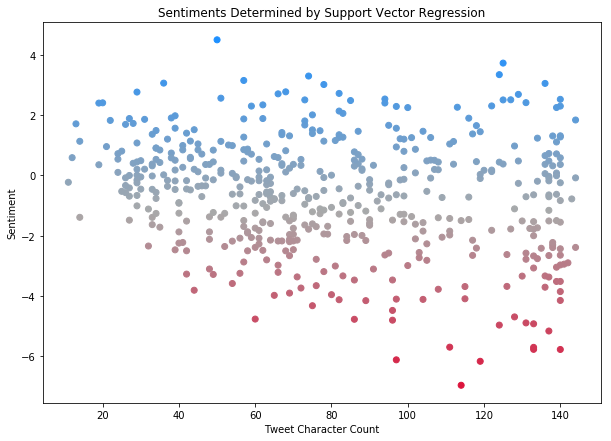

In [28]:
target_svr_sentiments = svr_model.predict(target_dataset)
sentiment_scatterplot(X, 
                      y = target_svr_sentiments, 
                      title = 'Sentiments Determined by Support Vector Regression');

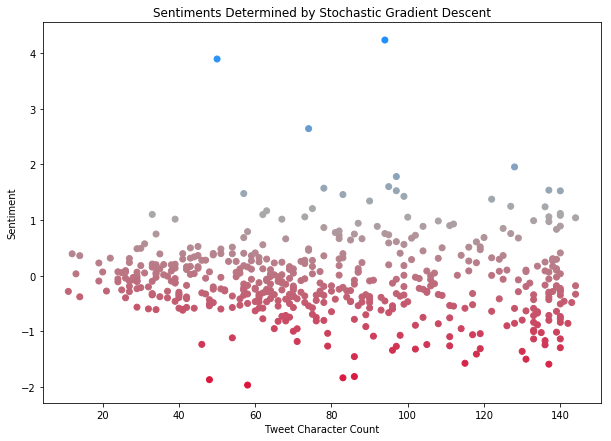

In [32]:
target_sgd_sentiments = sgd_model.predict(target_dataset)
sentiment_scatterplot(X,
                      y = target_sgd_sentiments,
                      title = 'Sentiments Determined by Stochastic Gradient Descent');

As you can see, there is a considerable difference between these two models.